In [1]:
import torch
import random
import math
import hess
import hess.utils as utils
import matplotlib.pyplot as plt
from hess.nets import Transformer
import hess.loss_surfaces as loss_surfaces
from hess.data import data_loader
import numpy as np
import copy

In [22]:
def twospirals(n_points, noise=.5, random_state=920):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 600 * (2*np.pi)/360
    d1x = -1.5*np.cos(n)*n + np.random.randn(n_points,1) * noise
    d1y =  1.5*np.sin(n)*n + np.random.randn(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [23]:
X, Y = twospirals(500, noise=1.3)
test_x, test_y = twospirals(100, 1.3)

In [24]:
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(Y).unsqueeze(-1)

test_x = torch.FloatTensor(test_x)
test_y = torch.FloatTensor(test_y).unsqueeze(-1)

In [25]:
optimus = Transformer(train_x, train_y, net=hess.nets.MoonNet, n_hidden=3, hidden_size=10,
                     activation=torch.nn.ELU(), bias=True)
network = optimus.net
loss_func = torch.nn.BCEWithLogitsLoss()

In [26]:
use_cuda =  torch.cuda.is_available()
if use_cuda:
    torch.cuda.set_device(2)
    train_x, train_y = train_x.cuda(), train_y.cuda()
    test_x, test_y = test_x.cuda(), test_y.cuda()
    network = network.cuda()
    optimus = optimus.cuda()

In [27]:
def mask_pars(p, mask):
    p.data = p.data * mask
    
def mask_maker(n_keep, n_total, use_cuda=False):
    mask = [1 for i in range(n_keep)] + [0 for i in range(n_total - n_keep)]
    mask = torch.tensor(mask)
    perm = np.random.permutation(n_total)
    mask = mask[perm]
    if use_cuda:
        mask = mask.cuda()
    return mask, perm

In [28]:
n_trial = 100
pct_keep = .75
n_par = sum(torch.numel(p) for p in network.parameters())
n_keep = int(pct_keep * n_par)

losses = torch.zeros(n_trial)
test_losses = torch.zeros(n_trial)
hessians = torch.zeros(n_trial, n_keep, n_keep)
for tt in range(n_trial): 
    
    ## set up the mask to generate a subnetwork ##
    temp_net = copy.deepcopy(network)
    mask, perm = mask_maker(n_keep, n_par, use_cuda)

    mask = utils.unflatten_like(mask.unsqueeze(0), temp_net.parameters())
    [mask_pars(p, mask[i]) for i, p in enumerate(temp_net.parameters())]
    
    ## compute the hessian of the masked network ##
    sub_hess = torch.zeros(n_par, n_par)
    for pp in range(n_par):
        base_vec = torch.zeros(n_par).unsqueeze(0).cuda()
        base_vec[0, pp] = 1.

        base_vec = utils.unflatten_like(base_vec, temp_net.parameters())
        utils.eval_hess_vec_prod(base_vec, temp_net.parameters(),
                                net=temp_net,
                                criterion=torch.nn.BCEWithLogitsLoss(),
                                inputs=train_x, targets=train_y)
        if pp == 0:
            output = utils.gradtensor_to_tensor(temp_net, include_bn=True)
            sub_hess = torch.zeros(output.nelement(), output.nelement())
            sub_hess[:, pp] = output


        sub_hess[:, pp] = utils.gradtensor_to_tensor(temp_net, include_bn=True).cpu()
    
    ## extract the indices of the hessian we care about ##
    keepers = np.array(np.where(perm < n_keep))[0]
    hessians[tt, :, :] = sub_hess[np.ix_(keepers, keepers)]
    
    ## now compute the losses for the subnetwork ##
    outputs = temp_net(train_x)
    losses[tt] = loss_func(outputs, train_y)
    
    outputs = temp_net(test_x)
    test_losses[tt] = loss_func(outputs, test_y)
    if tt%10 == 0:
        print("model ", tt, "done")

model  0 done
model  10 done
model  20 done
model  30 done
model  40 done
model  50 done
model  60 done
model  70 done
model  80 done
model  90 done


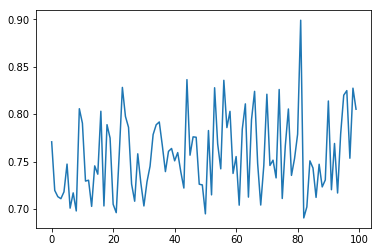

In [29]:
plt.plot(losses.detach())

In [30]:
optimus = optimus.cpu()
optimus.train_net(print_loss=True, lr=0.01, iters=2000,
                 loss_func=torch.nn.BCEWithLogitsLoss())

tensor(0.8693, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7788, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7260, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6972, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6811, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6703, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6617, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6546, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6493, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6460, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6445, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6441, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6440, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6436, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6427, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6412, grad_fn=<BinaryCrossEntropyWithLogitsBac

tensor(0.1936, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1933, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1930, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1926, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1921, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1917, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1911, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1905, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1899, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1893, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1887, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1882, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1878, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1873, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1869, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1865, grad_fn=<BinaryCrossEntropyWithLogitsBac

tensor(0.1557, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1556, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1555, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1555, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1554, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1553, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1552, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1551, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1551, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1550, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1549, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1548, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1547, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1547, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1547, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1547, grad_fn=<BinaryCrossEntropyWithLogitsBac

tensor(0.1501, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1496, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1486, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1493, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1476, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1484, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1489, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1470, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1476, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1482, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1472, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1475, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1472, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1469, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1475, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1470, grad_fn=<BinaryCrossEntropyWithLogitsBac

tensor(0.1409, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1407, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1416, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1415, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1409, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1409, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1412, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1408, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1403, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1405, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1408, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1407, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1404, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1403, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1404, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1403, grad_fn=<BinaryCrossEntropyWithLogitsBac

tensor(0.1361, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1363, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1365, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1362, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1361, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1363, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1361, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1359, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1361, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1361, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1359, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1359, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1359, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1359, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1358, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1358, grad_fn=<BinaryCrossEntropyWithLogitsBac

tensor(0.1326, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1325, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1325, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1325, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1325, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1324, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1324, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1325, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1324, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1324, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1323, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1323, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1323, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1323, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1323, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1323, grad_fn=<BinaryCrossEntropyWithLogitsBac

tensor(0.1372, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1430, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1443, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1470, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1409, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1354, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1346, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1367, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1404, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1358, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1318, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1303, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1327, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1363, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1341, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1311, grad_fn=<BinaryCrossEntropyWithLogitsBac

tensor(0.1271, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1271, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1271, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1270, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1270, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1270, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1270, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1270, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1270, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1270, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1269, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1269, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1269, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1269, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1269, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1269, grad_fn=<BinaryCrossEntropyWithLogitsBac

tensor(0.1255, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1254, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1253, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1253, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1254, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1254, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1253, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1253, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1253, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1253, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1253, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1253, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1252, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1252, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1252, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1252, grad_fn=<BinaryCrossEntropyWithLogitsBac

tensor(0.1241, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1247, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1250, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1245, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1242, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1245, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1245, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1242, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1242, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1244, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1243, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1240, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1240, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1242, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1242, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1240, grad_fn=<BinaryCrossEntropyWithLogitsBac

tensor(0.1229, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1228, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1229, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1230, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1230, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1229, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1229, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1228, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1228, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1228, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1228, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1228, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1228, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1228, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1227, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1227, grad_fn=<BinaryCrossEntropyWithLogitsBac

In [31]:
idx = losses.argsort()
losses = losses[idx]

In [32]:
idx

tensor([82, 50, 21,  8,  6, 83, 13, 30, 17, 61, 68, 20, 27,  3, 75, 86, 64,  2,
        52, 93,  7,  4,  1, 91, 43, 88, 49, 48, 26, 29, 31, 11, 12, 89, 73, 78,
        15, 59, 42, 37, 55, 85, 32, 14, 69, 71, 87,  5, 67, 84, 40, 72, 79, 97,
        60, 45, 28, 22, 41, 38, 39, 36, 76, 54, 92,  0, 19, 47, 46, 33, 80, 94,
        51, 62, 57, 25, 34, 18, 10, 35, 65, 24, 58, 16, 99, 77,  9, 63, 90, 95,
        70, 66, 96, 74, 98, 53, 23, 56, 44, 81])

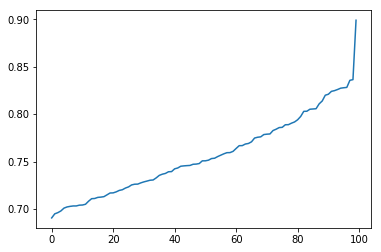

In [33]:
plt.plot(losses.detach())

In [34]:
hessians = hessians[idx, :, :]

In [35]:
e_vals = torch.zeros(n_trial, n_keep)
for tt in range(n_trial):
    e_val, _ = np.linalg.eig(hessians[tt, :, :].cpu())
    idx = np.abs(e_val).argsort()[::-1]   
    e_val = torch.FloatTensor(e_val[idx].real)
    e_vals[tt, :] = e_val

In [36]:
x_plt = torch.zeros_like(e_vals)
for tt in range(n_trial):
    x_plt[tt, :] = tt

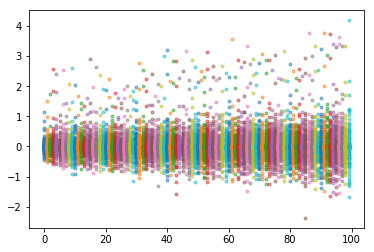

In [37]:
for tt in range(n_trial):
    plt.plot(x_plt[tt, :], e_vals[tt, :],
            marker='.', alpha=0.5, linestyle='None')

In [38]:
mean_eval = torch.mean(e_vals, 1)

In [39]:
mean_eval.shape

torch.Size([100])

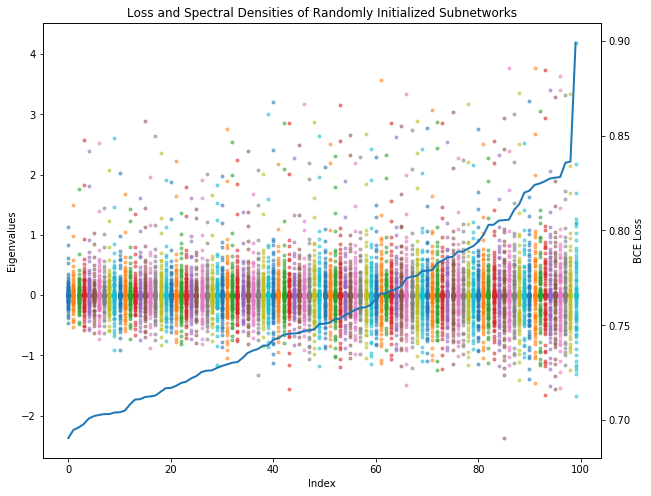

In [40]:
fig, ax1 = plt.subplots(figsize=(10,8))
for tt in range(n_trial):
    ax1.plot(x_plt[tt, :], e_vals[tt, :],
            marker=".", alpha=0.5, linestyle='None')
ax1.set_ylabel("Eigenvalues")


ax2 = ax1.twinx()
ax2.plot(x_plt[:, 0], losses.detach(),
        linewidth=2.)
ax2.set_ylabel("BCE Loss")
ax1.set_xlabel("Index")
plt.title("Loss and Spectral Densities of Randomly Initialized Subnetworks");

In [41]:
outputs = optimus(train_x.cpu())
outputs = torch.zeros_like(outputs)
ll = loss_func(outputs, train_y.cpu())